## Load, enrich, augment and clean the data

In [1]:
# dataset is taken from Kaggle and downloaded from here:
# https://www.kaggle.com/datasets/thomasnibb/amsterdam-house-price-prediction
# license is CC0: Public Domain - can copy, modify, distribute and perform the work, 
# even for commercial purposes, all without asking permission.

import pandas as pd
import numpy as np

pd.set_option('display.float_format', '{:.4f}'.format) # to kill scientific notation..


import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv("HousingPrices-Amsterdam-August-2021.csv")
df.head() # look of the original dataset


,Unnamed: 0,Address,Zip,Price,Area,Room,Lon,Lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0000,64,3,4.9077,52.3562
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0000,60,3,4.8505,52.3486
2,3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0000,109,4,4.9448,52.3438
3,4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0000,128,6,4.7899,52.3437
4,5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0000,138,5,4.9025,52.4105


In [2]:
# STEP 0 - make column names look good:
df.columns = df.columns.str.lower()

# We will use only 4 columns for the start
df['pc4'] = df.zip.str.split().str[0]
used_cols = ['pc4', 'area', 'room', 'price']
df = df[used_cols]

df.head(1)

,pc4,area,room,price
0,1091,64,3,685000.0000


In [3]:
df.describe()

,area,room,price
count,924.0000,924.0000,920.0000
mean,95.9524,3.5714,622065.4196
std,57.4474,1.5923,538994.1754
min,21.0000,1.0000,175000.0000
25%,60.7500,3.0000,350000.0000
50%,83.0000,3.0000,467000.0000
75%,113.0000,4.0000,700000.0000
max,623.0000,14.0000,5950000.0000


In [4]:
# We skipped mappings and focus only on 3 features - pc4, area and rooms
df.pc4.nunique() # 70 - much better for grouping than original zip


70

<Axes: xlabel='price', ylabel='Count'>

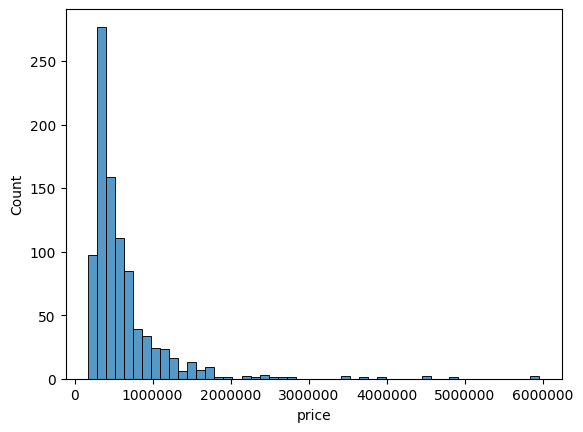

In [5]:
# Look at the price variable. Does it have a long tail - YES!!

plt.ticklabel_format(style='plain')
sns.histplot(df.price, bins=50) 

In [6]:
# make number of rooms and area as integers
df['area'] = df['area'].astype('int64')
df['room'] = df['room'].astype('int64')

# missing values - count:
df.isna().sum()

pc4      0
area     0
room     0
price    4
dtype: int64

In [7]:
# As we have only 4 rows with missing price out of 924 we can delete it

df = df.dropna(subset=['price'])
df['price'] = df['price'].astype('int64')
df.describe()


,area,room,price
count,920.0000,920.0000,920.0000
mean,95.6076,3.5641,622065.4196
std,56.8497,1.5710,538994.1754
min,21.0000,1.0000,175000.0000
25%,60.0000,3.0000,350000.0000
50%,83.0000,3.0000,467000.0000
75%,113.0000,4.0000,700000.0000
max,623.0000,14.0000,5950000.0000


In [8]:
# max price is about 6M euro, while mean is anout 600K - we have to convert price to logariphnic form
# so our models would not be confused by a large number

df.price = np.log1p(df.price)
df.head()


,pc4,area,room,price
0,1091,64,3,13.4372
1,1059,60,3,13.0711
2,1097,109,4,13.6530
3,1060,128,6,13.2708
4,1036,138,5,13.4870


<Axes: xlabel='price', ylabel='Count'>

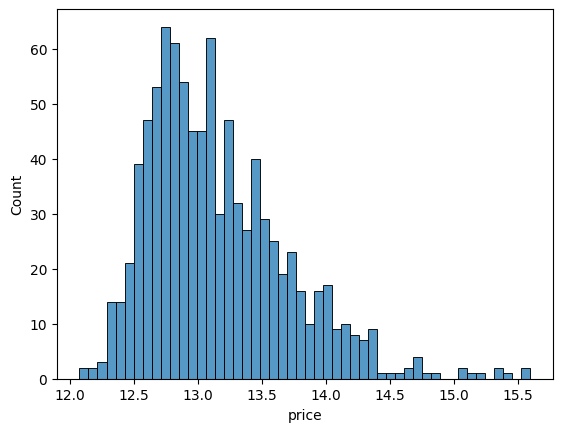

In [9]:
# print distribution of our price data in a log form:

plt.ticklabel_format(style='plain')
sns.histplot(df.price, bins=50) 

## Split dataset for training with 60%/20%/20% distribution

In [10]:
# Do train/validation/test split with 60%/20%/20% distribution.
# Use the train_test_split function and set the random_state parameter to 1.

from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [11]:
len(df_full_train), len(df_test) # (736, 184)


(736, 184)

In [12]:
len(df_train), len(df_val)  # (552, 184)

(552, 184)

In [13]:
# reset index in splits

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
# prepare label (target variable)
y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values
len(y_train), len(y_val), len(y_test)
# (552, 184, 184)

(552, 184, 184)

In [15]:
# remove label so model cannot learn from it accidentally

del df_train['price']
del df_val['price']
del df_test['price']

In [16]:
# check all good
# df_test.head()
df_train.pc4.nunique() 
# 69 - our training dataset will be chubby - 552 rows and 71 columns - about 1:8 ratio - danger of overfitting...

69

In [17]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

# we use many categorical features, thus one-hot encoding is needed:
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text

train_dicts = df_train.to_dict(orient='records')
# train_dicts[:5] # quick check - all looks good

In [18]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts) 
# DictVectorizer for 1-hot encoding of our training dataset, 
# in X_train we can use only fit_transform

In [19]:
# CHECK 1:
dv.get_feature_names_out() # after 1-hot encoding how our features look like...


array(['area', 'pc4=1011', 'pc4=1012', 'pc4=1013', 'pc4=1014', 'pc4=1015',
       'pc4=1016', 'pc4=1017', 'pc4=1018', 'pc4=1019', 'pc4=1021',
       'pc4=1023', 'pc4=1024', 'pc4=1025', 'pc4=1027', 'pc4=1028',
       'pc4=1031', 'pc4=1032', 'pc4=1033', 'pc4=1034', 'pc4=1035',
       'pc4=1036', 'pc4=1051', 'pc4=1052', 'pc4=1053', 'pc4=1054',
       'pc4=1055', 'pc4=1056', 'pc4=1057', 'pc4=1058', 'pc4=1059',
       'pc4=1060', 'pc4=1061', 'pc4=1062', 'pc4=1063', 'pc4=1064',
       'pc4=1065', 'pc4=1066', 'pc4=1067', 'pc4=1068', 'pc4=1069',
       'pc4=1071', 'pc4=1072', 'pc4=1073', 'pc4=1074', 'pc4=1075',
       'pc4=1076', 'pc4=1077', 'pc4=1078', 'pc4=1079', 'pc4=1081',
       'pc4=1082', 'pc4=1083', 'pc4=1086', 'pc4=1087', 'pc4=1091',
       'pc4=1092', 'pc4=1093', 'pc4=1094', 'pc4=1095', 'pc4=1096',
       'pc4=1097', 'pc4=1098', 'pc4=1102', 'pc4=1103', 'pc4=1104',
       'pc4=1106', 'pc4=1107', 'pc4=1108', 'pc4=1109', 'room'],
      dtype=object)

In [20]:
X_train[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 71)>

In [21]:
# X_val
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts) 
# In X_val we can use only transform
X_val[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 71)>

## Building a Linear Regression model

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# ------------------------
# 1. Train Linear Regression
# ------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# ------------------------
# 2. Predict on validation set
# ------------------------
y_pred = model.predict(X_val)

# ------------------------
# 3. Compute RMSE
# ------------------------
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE:", rmse)
# Linear regresson model RMSE: 0.34877

Validation RMSE: 0.3487718589610038


<Axes: ylabel='Count'>

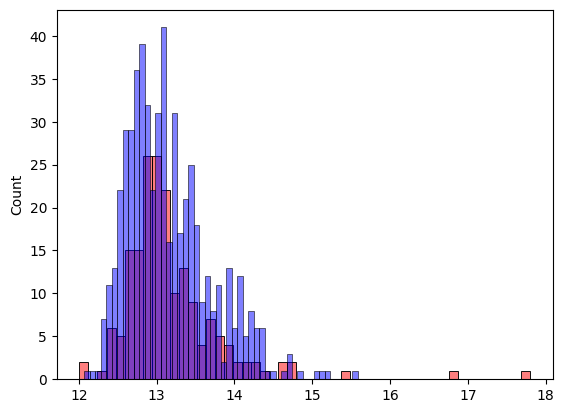

In [23]:
# we can plot predicted log1p price against our actual log1p price - RMSE
sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [24]:
# Fine tuning linear regression model using ridge regularization

alphas = [0, 0.00001, 0.0001, 0.001, 0.01, 1, 10]

from sklearn.linear_model import Ridge

for a in alphas:
    model = Ridge(alpha=a)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print(f"alpha={a:>8}  RMSE={rmse:.4f}")

# When training Ridge lin regression model best result is alpha = 1  RMSE = 0.3219 

alpha=       0  RMSE=0.3332
alpha=   1e-05  RMSE=0.3332
alpha=  0.0001  RMSE=0.3332
alpha=   0.001  RMSE=0.3332
alpha=    0.01  RMSE=0.3331
alpha=       1  RMSE=0.3219
alpha=      10  RMSE=0.3303


In [25]:
# Quick models comparison
# Linear regresson model RMSE: 0.3488
# Fine tuned Ridge lin reg model RMSE: 0.3219 - better!

## Building a Decision Tree Regressor model - short

In [26]:
# Let's train a decision tree regressor to predict the price variable.

# Short version - train a model with max_depth=1 to confirm our main feature
# Which feature is used for splitting the data -> area


# we are building a regressor model - to predict price:
from sklearn.tree import DecisionTreeRegressor

# train the decision tree with max_depth=1.

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train) # NB - max_depth 1

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [27]:
# now how to find which feature is used for splitting the data -
from sklearn.tree import export_text
# and get weight coefficients for our decisions
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

# Speculation - houses and apartments with area less than 110 M2 considered mass market
# and ones bigger than 110 M2 considered as luxury for Amsterdam...

|--- area <= 110.50
|   |--- value: [12.92]
|--- area >  110.50
|   |--- value: [13.79]



## Building a Random Forest Regressor model

In [28]:
# Train a random forest regressor with these parameters:

# n_estimators=10
# random_state=1
# n_jobs=-1 (optional - to make training faster)
# What's the RMSE of this model on the validation data - 

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1  
)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
# prepare X_val

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = rf.predict(X_val)

# What's the RMSE of random forest regressor model on the validation data?
from sklearn.metrics import mean_squared_error

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}") 
# Before logariphmic price RMSE: 327310.8777
# After log conversion RMSE: 0.2758

# Quick models comparison
# Linear regresson model RMSE: 0.3488
# Fine tuned Ridge lin reg model RMSE: 0.3219
# Random Forest Regressor model RMSE: 0.2758 - better!

RMSE: 0.2758


In [30]:
# Check myself another way
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

score = round(rmse(y_val, y_pred), 4)
float(score) 
# same result as above 0.2758

0.2758

In [31]:
# Let's experiment with the n_estimators hyperparameter

# Try different values of this parameter from 10 to 200 with step 10.
# Set random_state to 1.
# Evaluate the model on the validation dataset.
# After which value of n_estimators does RMSE stop improving = 40

scores = []

from tqdm.auto import tqdm

for p in tqdm(range(10, 201, 10)):
    # experiment with the n_estimators parameter
    rf = RandomForestRegressor(
    n_estimators=p,
    random_state=1,
    n_jobs=-1  
    )
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)

    score = round(rmse(y_val, y_pred), 4)
    scores.append((p, score))
    print(p, score)
    
# scores

C:\tmp\amsterdam-housing-price-prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|                                                         | 0/20 [00:00<?, ?it/s]

10 0.2758


 10%|████▉                                            | 2/20 [00:00<00:00, 18.93it/s]

20 0.2686
30 0.2689


 20%|█████████▊                                       | 4/20 [00:00<00:01, 14.71it/s]

40 0.2667
50 0.2673


 30%|██████████████▋                                  | 6/20 [00:00<00:01, 11.10it/s]

60 0.268
70 0.268


 40%|███████████████████▌                             | 8/20 [00:00<00:01,  9.11it/s]

80 0.2676
90 0.2676


 55%|██████████████████████████▍                     | 11/20 [00:01<00:01,  6.67it/s]

100 0.2684
110 0.2683


 65%|███████████████████████████████▏                | 13/20 [00:01<00:01,  5.97it/s]

120 0.2677
130 0.2682


 70%|█████████████████████████████████▌              | 14/20 [00:01<00:01,  5.60it/s]

140 0.2679


 75%|████████████████████████████████████            | 15/20 [00:02<00:00,  5.09it/s]

150 0.2681


 80%|██████████████████████████████████████▍         | 16/20 [00:02<00:00,  4.81it/s]

160 0.2687


 85%|████████████████████████████████████████▊       | 17/20 [00:02<00:00,  4.53it/s]

170 0.2681


 90%|███████████████████████████████████████████▏    | 18/20 [00:02<00:00,  4.22it/s]

180 0.2683


 95%|█████████████████████████████████████████████▌  | 19/20 [00:03<00:00,  3.88it/s]

190 0.2687


100%|████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.63it/s]

200 0.2688


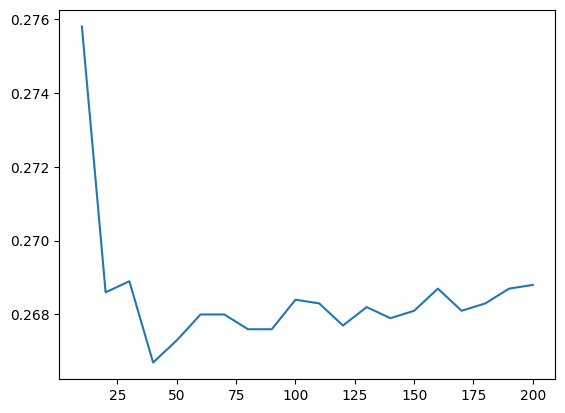

In [32]:
import seaborn as sns
from matplotlib import pyplot as plt

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
plt.plot(df_scores.n_estimators, df_scores.rmse) 
# plt.legend()

In [33]:
# Let's select the best max_depth:

# Try different values of max_depth: [10, 15, 20, 25]
# For each of these values,
# try different values of n_estimators from 10 till 200 (with step 10)
# calculate the mean RMSE
# Fix the random seed: random_state=1
# What's the best max_depth, using the mean RMSE = 20


mean_rmse = []
total_rmse = []

for d in tqdm([10, 15, 20, 25]):
    scores = []
    for p in tqdm(range(10, 201, 10)):
        # experiment with the n_estimators parameter and max_depth:
        rf = RandomForestRegressor(
        n_estimators=p,
        max_depth=d,
        random_state=1,
        n_jobs=-1  
        )
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict(X_val)
    
        score = round(rmse(y_val, y_pred), 4)
        scores.append(score)

    s = np.mean(scores)
    total_rmse.append(scores) # in case we may plot every max_depth curve later
    mean_rmse.append((d, s))
    std_rmse = np.std(scores)
    print(f"Mean RMSE: {s:.4f} ± {std_rmse:.4f} for max_depth: {d:.0f}")


mean_rmse

 25%|████████████▌                                     | 1/4 [00:03<00:09,  3.16s/it]

Mean RMSE: 0.2816 ± 0.0010 for max_depth: 10



 50%|█████████████████████████                         | 2/4 [00:06<00:06,  3.23s/it]

Mean RMSE: 0.2705 ± 0.0016 for max_depth: 15



 75%|█████████████████████████████████████▌            | 3/4 [00:09<00:03,  3.31s/it]

Mean RMSE: 0.2679 ± 0.0023 for max_depth: 20



100%|██████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.32s/it]

Mean RMSE: 0.2683 ± 0.0025 for max_depth: 25


[(10, np.float64(0.28160999999999997)),
 (15, np.float64(0.270455)),
 (20, np.float64(0.267905)),
 (25, np.float64(0.26831499999999997))]

In [34]:
# We can extract feature importance information from tree-based models.

# At each step of the decision tree learning algorithm, it finds the best split. 
# When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
# This gain is quite useful in understanding what are the important features for tree-based models.

# In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

# Lets find the most important feature:

# Train the model with our best parameters after fine tuning:
# n_estimators=40,
# max_depth=20,
# random_state=1,
# n_jobs=-1 (optional)
# Get the feature importance information from this model

# What's the most important feature (among these 3) = area, value: 0.8326
# This is corresponding with our previous obzervation

rf = RandomForestRegressor(
n_estimators=40,
max_depth=20,
random_state=1,
n_jobs=-1  
)
rf.fit(X_train, y_train)
rf

,n_estimators,40
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [35]:
for f, v in zip(dv.get_feature_names_out(), rf.feature_importances_):
     print(f"Feature name: {f}, value: {v:.4f}") 

Feature name: area, value: 0.7627
Feature name: pc4=1011, value: 0.0046
Feature name: pc4=1012, value: 0.0016
Feature name: pc4=1013, value: 0.0007
Feature name: pc4=1014, value: 0.0023
Feature name: pc4=1015, value: 0.0054
Feature name: pc4=1016, value: 0.0043
Feature name: pc4=1017, value: 0.0103
Feature name: pc4=1018, value: 0.0020
Feature name: pc4=1019, value: 0.0021
Feature name: pc4=1021, value: 0.0003
Feature name: pc4=1023, value: 0.0012
Feature name: pc4=1024, value: 0.0098
Feature name: pc4=1025, value: 0.0085
Feature name: pc4=1027, value: 0.0017
Feature name: pc4=1028, value: 0.0001
Feature name: pc4=1031, value: 0.0002
Feature name: pc4=1032, value: 0.0005
Feature name: pc4=1033, value: 0.0024
Feature name: pc4=1034, value: 0.0053
Feature name: pc4=1035, value: 0.0031
Feature name: pc4=1036, value: 0.0004
Feature name: pc4=1051, value: 0.0002
Feature name: pc4=1052, value: 0.0005
Feature name: pc4=1053, value: 0.0012
Feature name: pc4=1054, value: 0.0035
Feature name: pc

<Axes: ylabel='Count'>

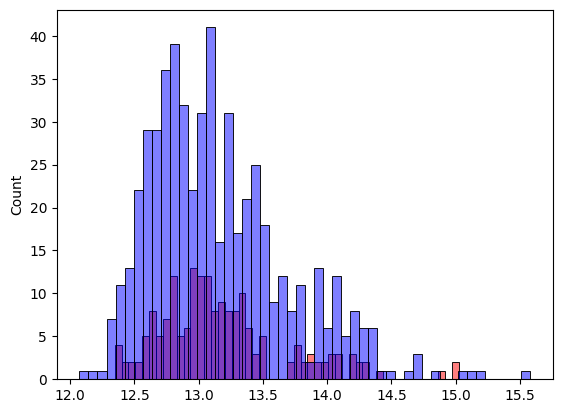

In [36]:
# plot predicted price against our actual price - RMSE
y_pred = rf.predict(X_val)

sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [37]:
# Compute RMSE of our fine-tuned version of RF model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}") 

# Quick models comparison
# Linear regresson model RMSE: 0.3488
# Fine tuned Ridge lin reg model RMSE: 0.3219
# Random Forest Regressor model RMSE before fine tuning: 0.2758
# Random Forest Regressor model RMSE after fine tuning: 0.2430 - better!

# We can use our fine tuned parameters for rf model later:
# n_estimators=40,
# max_depth=20,
# random_state=1,
# n_jobs=-1

RMSE: 0.2664


## Building an XGBoost model

In [38]:
# let's train an XGBoost model and fine tune the eta parameter:

# Install XGBoost
# Create DMatrix for train and validation
# Train a model with these parameters for 100 rounds

import xgboost as xgb

In [39]:
# Create DMatrix for train and validation
# xgboost needs d-matrix for train - a special data structure:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [40]:
# Train a model with these parameters for 100 rounds:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [41]:
y_pred = model.predict(dval)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}")
# Better compared to RF model - 
# Xgboost model RMSE: 0.2262 if 'eta': 0.3


RMSE: 0.2262


<Axes: ylabel='Count'>

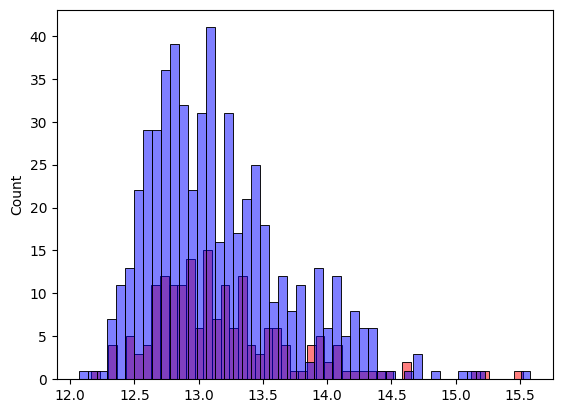

In [42]:
# we can plot predicted price against our actual price - RMSE

sns.histplot(y_pred, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [43]:
# Quick models comparison
# Linear regresson model RMSE: 0.3488
# Fine tuned Ridge lin reg model RMSE: 0.3219
# Fine tuned Ridge lin reg model RMSE: 0.3219
# Random Forest Regressor model RMSE before fine tuning: 0.2758
# Random Forest Regressor model RMSE after fine tuning: 0.2430 
# Xgboost model RMSE: 0.2262 with 'eta': 0.3 - better!

In [44]:
# Fine tuning XGBoost model

max_depth_list = [4, 6, 8]
min_child_list = [1, 5, 10]

best_rmse = 999
best_params = None

for md in max_depth_list:
    for mcw in min_child_list:

        params = {
            'eta': 0.3,
            'max_depth': md,
            'min_child_weight': mcw,
            'objective': 'reg:squarederror',
            'seed': 1,
            'nthread': 8,
        }

        model = xgb.train(params, dtrain, num_boost_round=100)
        y_pred = model.predict(dval)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        print(f"max_depth={md}, min_child_weight={mcw}, RMSE={rmse:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (md, mcw)

print("\nBEST:", best_params, best_rmse)

# max_depth=6, min_child_weight=1, RMSE=0.2262

# Best fine tuned params for XGB model are still the same:
# params = {
#     'eta': 0.3,
#     'max_depth': 6,
#     'min_child_weight': 1,
#     'objective': 'reg:squarederror',
#     'seed': 1,
#     'nthread': 8,
# }


max_depth=4, min_child_weight=1, RMSE=0.2282
max_depth=4, min_child_weight=5, RMSE=0.2407
max_depth=4, min_child_weight=10, RMSE=0.2817
max_depth=6, min_child_weight=1, RMSE=0.2262
max_depth=6, min_child_weight=5, RMSE=0.2525
max_depth=6, min_child_weight=10, RMSE=0.2945
max_depth=8, min_child_weight=1, RMSE=0.2419
max_depth=8, min_child_weight=5, RMSE=0.2586
max_depth=8, min_child_weight=10, RMSE=0.3034

BEST: (6, 1) 0.2261748994125695


In [45]:
# Quick models comparison
# Linear regresson model RMSE: 0.3488
# Fine tuned Ridge lin reg model RMSE: 0.3219
# Fine tuned Ridge lin reg model RMSE: 0.3219
# Random Forest Regressor model RMSE before fine tuning: 0.2758
# Random Forest Regressor model RMSE after fine tuning: 0.2430 
# Xgboost model RMSE: 0.2262 with 'eta': 0.3
# Xgboost fine tuned model RMSE: 0.2262 with max_depth=6, min_child_weight=1, eta=0.3
# - basically the result already a good one!

## Training the final model and final test on test dataset

In [46]:
# Prepare final training dataset by merging train and val
# df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1) # we did it already above
len(df_full_train), len(df_test) # (736, 184)

(736, 184)

In [47]:
# reset index in full train:
df_full_train = df_full_train.reset_index(drop=True)

In [48]:
# prepare label (target variable)
y_full_train = df_full_train.price.values
len(y_full_train), len(y_test) # (736, 184)

(736, 184)

In [49]:
# remove label so model cannot learn from it accidentally
del df_full_train['price']
df_full_train.head()

,pc4,area,room
0,1032,61,1
1,1012,116,4
2,1017,53,2
3,1024,77,4
4,1018,26,1


In [50]:
# Prepare dicts:
full_train_dicts = df_full_train.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

X_full_train = dv.fit_transform(full_train_dicts) 
X_test = dv.transform(test_dicts) 

# Build dmatrices:
d_full_train = xgb.DMatrix(X_full_train, label=y_full_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)


In [51]:
# Train the model with fine tuned parameters for 100 rounds:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)
model

In [52]:
y_pred = model.predict(dtest)

# Compute RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}") 

# On full train we get RMSE: 0.1948
# Improvement over original XGB model RMSE: 0.2262 - no overfitting!!


RMSE: 0.1948


In [53]:
# Pickle the model and save it to a local file:
# XGBoost has its own built-in serialization, which is more stable than Python pickle.
model.save_model("xgb_model_Ams_17.11.2025.json")


## Appendix

In [54]:
# df.zip.nunique() # 834 - too many for grouping...

In [55]:
# df.address.nunique() # 919 - too many as well...

In [56]:
# idea - we need to extract city districts (wijk in Dutch) based on the zip/street address
# collect a sentiment score for each district in range 1-10 using LLM - good or bad for living
# and add it as columns to our dataset - district and sentiment - as realtors often say - location, location, location...

# I decided to drop GPS lat long columns - not to mess up with Google maps API for simplicity
# and used Amsterdam district names from here:
# https://data.europa.eu/data/datasets/22433-postcode-buurt-wijk?locale=da

# idea 2 - in Amsterdam city district - wijk consists of subdistricts - buurt
# which consists of PC4 post codes (first 4 digits of zip column in our dataset)
# I will drop the street address for now and map buurt and wijk from downloaded CSV to PC4

In [57]:
# small explanation how Dutch postal addresses are organised
# The PC4 (first four digits of zip code) identifies a broad area within a city — 
# this can be mapped to neighbourhood or district statistically.
# The PC6 (full 6 characters of zip code, including letters) often maps to one side 
# of a street, or even a cluster of house numbers.
# The letter pair (e.g., CR in zip = '1091 CR') is simply a unique subdivision to make post sorting precise.

# Example:
# full zip  = 1091 CR
# street address: Blasiusstraat 8 2, Amsterdam
# Neighbourhood (Buurt): Weesperzijde
# District (Wijk): Oud-Oost
# Part of the city (Stadsdeel): Amsterdam-Oost

# so the naming hierachy is postcode → buurt → wijk


# prepare our df zip code col for mapping
# df['pc4'] = df.zip.str.split().str[0]
# df['PC6'] = df.zip.str.replace(' ', '')
# df.head(1)

In [58]:
# df.pc4.nunique() # 70 - much better for grouping

In [59]:
# STEP 2 - download district and area codes - buurt and wijk - from national statistics bureau:
# https://www.cbs.nl/nl-nl/maatwerk/2023/35/buurt-wijk-en-gemeente-2023-voor-postcode-huisnummer

# mapping = pd.read_csv('pc6hnr20230801_gwb.csv', delimiter=';')
# mapping.head(1)

In [60]:
# merge dataframes

# df = df.merge(mapping, on='PC6')
# df